# Aviatrix Analytics Assignment

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('test_data.csv', parse_dates=['CreatedAt'])
df

,CreatedAt,Currency,UserId,PlatformId,MatchId,stake_currency,stake_eur,won_currency,won_eur
0,2023-03-20 15:01:13.304718058,KZT,wqsjm3ggga,platform_2,1013616,203.29,0.41,0.00,0.00
1,2023-03-13 13:40:07.304718058,TRY,enrlnd1u6y,platform_4,982714,1.88,0.09,5.79,0.29
2,2023-03-22 00:39:12.304718058,KZT,5nz03e471b,platform_1,1019784,605.22,1.21,0.00,0.00
3,2023-03-22 06:14:56.304718058,KZT,fiatnpu27d,platform_2,1020804,33.99,0.07,0.00,0.00
4,2023-03-01 14:32:41.304718058,KZT,1zx0tpf58u,platform_1,930347,18.93,0.04,0.00,0.00
...,...,...,...,...,...,...,...,...,...
99984,2023-03-27 05:50:36.304718058,KZT,yy04sqqhsn,platform_2,1042809,73.09,0.15,73.09,0.15
99985,2023-04-05 14:17:12.304718058,TRY,w86x6fnbx5,platform_2,1083864,5.73,0.27,0.00,0.00
99986,2023-03-11 19:34:34.304718058,KZT,w87kmjmmuc,platform_3,975059,26.22,0.05,0.00,0.00
99987,2023-03-31 21:33:30.304718058,KZT,bkwmgy6e6b,platform_1,1063176,88.01,0.18,0.00,0.00


## Identify and describe errors in the data

Types of data seem to be consistent with what they represent.

In [4]:
df.dtypes

CreatedAt         datetime64[ns]
Currency                  object
UserId                    object
PlatformId                object
MatchId                    int64
stake_currency           float64
stake_eur                float64
won_currency             float64
won_eur                  float64
dtype: object

From the very start we can see that the platform column registers platforms as listed below. \
This is not fitting for a good analysis, because one does not actually know from which platform a bet was made.

In [5]:
df['PlatformId'].unique()

array(['platform_2', 'platform_4', 'platform_1', 'platform_3'],
      dtype=object)

Lets try to see if there are any missing values in data. \
There is no missing data in the dataframe.

In [6]:
df[df.isna().any(axis=1)]

,CreatedAt,Currency,UserId,PlatformId,MatchId,stake_currency,stake_eur,won_currency,won_eur


There are also no duplicate entries.

In [7]:
df[df.duplicated()]

,CreatedAt,Currency,UserId,PlatformId,MatchId,stake_currency,stake_eur,won_currency,won_eur


The currencies seem to fit to the world definitions:
- KZT - Kazakhstan tenge
- TRY - TUrkey lire
- AZN - Azerbaijani manat
- INR - Indian rupee

In [8]:
df.Currency.unique()

array(['KZT', 'TRY', 'AZN', 'INR'], dtype=object)

**There seem to be no more errors apart from names of platforms.**

## A Brief Report: Description Metrics

Lets start with data overview.

Since every row is a single bet, we can say that the dataset contains about 100 thousand bets.

In [9]:
num_rows = len(df)
num_columns = len(df.columns)

print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

Number of Rows: 99989
Number of Columns: 9


Now, lets look at the general summary statistics of datetime, euros bet (stake_eur) and euros won (won_eur).

We can see that there is 36 days worth of data in the dataset.

As we can see, the difference between mean euros bet and mean euros won is small, but the median for euros won is 0. \
It means that the first 50% of players bet from 0 to 0.21 euros, but win nothing. \
However, top 25% of players win from 0.25 euros up to 14569.58 euros.

In [10]:
df.drop(columns=['MatchId', 'stake_currency', 'won_currency']).describe()

,CreatedAt,stake_eur,won_eur
count,99989,99989.000000,99989.000000
mean,2023-03-17 10:43:32.748456960,1.598604,1.491250
min,2023-02-25 00:00:02.304718058,0.000000,0.000000
25%,2023-03-07 05:59:04.304718080,0.090000,0.000000
50%,2023-03-17 09:50:28.304718080,0.210000,0.000000
75%,2023-03-27 19:31:43.304718080,0.820000,0.250000
max,2023-04-06 23:37:06.304718058,320.050000,1469.580000
std,NaN,8.243046,14.491416


We can see an enormous skewness towards the left for euros bet and won both by currencies and platforms. \
It means that most of the bets and euors won were small. Only a small number of players bet and/or gained substancial winnings. \
Also, we can see 

ValueError: The `stat` parameter for `Hist` must be one of 'count', 'density', 'percent', 'probability' or 'frequency'; not 'sum'.

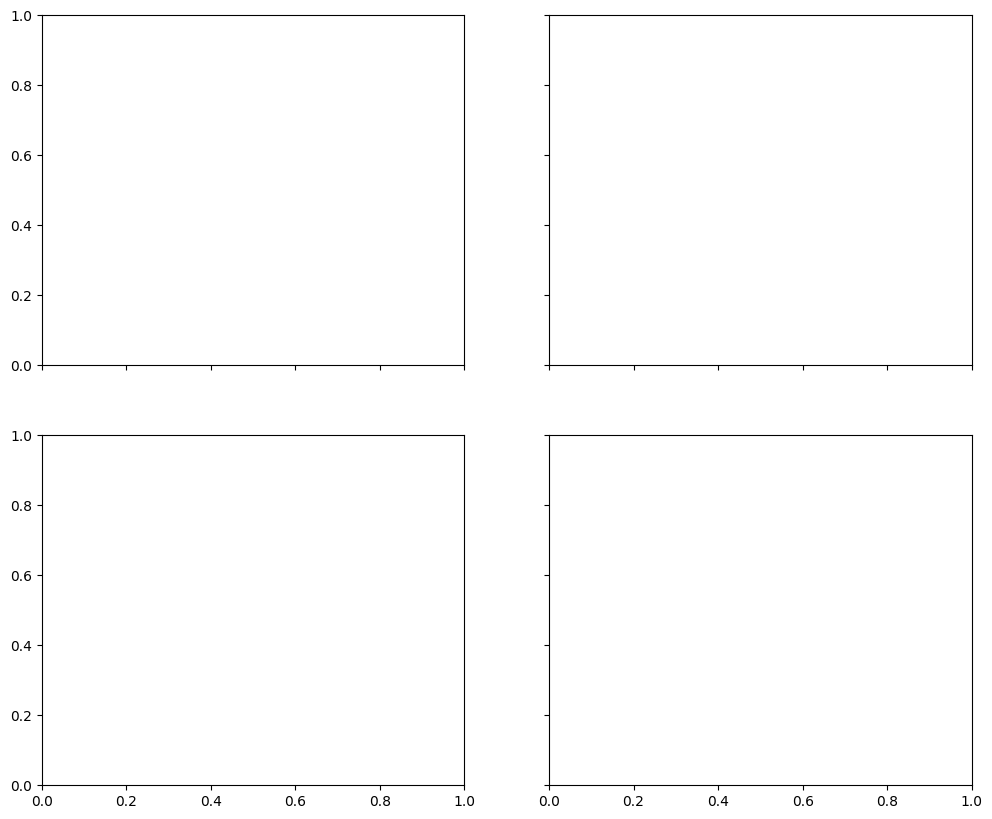

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True ,sharey=True)

sns.histplot(data=df, x='stake_eur', hue='Currency', alpha=0.3, bins=200, element="step", ax=axes[0, 0])
axes[0, 0].set_title("Euros bet by currency")
axes[0, 0].set_ylim(0, 4000)
axes[0, 0].set_xlim(0, 40)

sns.histplot(data=df, x='won_eur', hue='Currency', alpha=0.3, bins=200, element="step", ax=axes[0, 1])
axes[0, 1].set_title("Euros won by currency")
axes[0, 1].set_ylim(0, 4000)
axes[0, 1].set_xlim(0, 40)

sns.histplot(data=df, x='stake_eur', hue='PlatformId', alpha=0.3, bins=200, element="step", ax=axes[1, 0])
axes[1, 0].set_title("Euros bet by platform")
axes[1, 0].set_ylim(0, 4000)
axes[1, 0].set_xlim(0, 40)

sns.histplot(data=df, x='won_eur', hue='PlatformId', alpha=0.3, bins=200, element="step", ax=axes[1, 1])
axes[1, 1].set_title("Euros won by platform")
axes[1, 1].set_ylim(0, 4000)
axes[1, 1].set_xlim(0, 40)

plt.show()

Lets create a model where columns are metrics and rows are categories:
- num_users - number of unique users
- num_bets - number of bets made
- avg_euros_bet - average amount of users bet
- total_euros_bet - total amount of euros bet
- total_euors_won - total amount of euors won
- profit_euros - total profit generated in euros after subtracting euros won from euros bet
- conversion - ratio of the total amount won to the total amount bet
- avg_freq_bet - average amount of bets per user
- peak_dow - peak day of the week when the most number of bets are made
- peak_tod - peak time of the day when the most number of bets are made

In [ ]:
df['Day_of_Week'] = df.CreatedAt.dt.day_name()

df['Hour'] = df.CreatedAt.dt.hour
bins = [-1, 5, 12, 17, 24]
labels = ['night', 'morning', 'afternoon', 'evening']
df['Time_of_Day'] = pd.cut(df['Hour'], bins=bins, labels=labels, right=False)

by_category = df.groupby(["Currency", "PlatformId"]) \
                .agg(num_users=('UserId', 'nunique'),
                    num_bets=('MatchId', 'count'),
                    avg_euros_bet=('stake_eur', 'mean'),
                    total_euros_bet=('stake_eur', 'sum'),
                    total_euros_won=('won_eur', 'sum'),
                    peak_dow=('Day_of_Week', lambda x: x.mode().iloc[0]),
                    peak_tod=('Time_of_Day', lambda x: x.mode().iloc[0]))

by_category['profit_euros'] = by_category.total_euros_bet - by_category.total_euros_won

by_category['conversion'] = (by_category.total_euros_won / by_category.total_euros_bet).round(2)

num_bets = df.groupby(['Currency', 'PlatformId', 'UserId']) \
             .agg(bet_frequency=('CreatedAt', 'count')) \
             .reset_index() \
             .groupby(['Currency', 'PlatformId']) \
             .agg(avg_freq_bet=('bet_frequency', 'mean'))

by_category = by_category.merge(num_bets, left_index=True, right_index=True)

peak_dow_move = by_category.pop('peak_dow')
by_category.insert(9, peak_dow_move.name, peak_dow_move)

peak_tod_move = by_category.pop('peak_tod')
by_category.insert(9, peak_tod_move.name, peak_tod_move)

by_category

num_users  num_bets  avg_euros_bet  total_euros_bet  \
Currency PlatformId                                                        
AZN      platform_2        579      3168       2.735565          8666.27   
         platform_3       1153      7575       2.113304         16008.28   
INR      platform_2       1468      7769       1.941913         15086.72   
         platform_3       1642      7078       1.373484          9721.52   
         platform_4         21        58       0.705345            40.91   
KZT      platform_1      11150     40363       0.837737         33813.58   
         platform_2       3148     14381       1.989264         28607.60   
         platform_3        571      2288       0.771080          1764.23   
TRY      platform_2        737      3720       3.108680         11564.29   
         platform_3        524      1896       4.064388          7706.08   
         platform_4       2443     11693       2.297385         26863.32   

                     total_euros_won  profit_euros  conversion  avg_freq_bet  \
Currency PlatformId                                                            
AZN      platform_2          7102.65       1563.62        0.82      5.471503   
         platform_3         15755.77        252.51        0.98      6.569818   
INR      platform_2         12027.75       3058.97        0.80      5.292234   
         platform_3          8301.43       1420.09        0.85      4.310597   
         platform_4            31.30          9.61        0.77      2.761905   
KZT      platform_1         35005.04      -1191.46        1.04      3.620000   
         platform_2         25197.47       3410.13        0.88      4.568297   
         platform_3          2147.01       -382.78        1.22      4.007005   
TRY      platform_2         11223.21        341.08        0.97      5.047490   
         platform_3          5258.80       2447.28        0.68      3.618321   
         platform_4         27058.17       -194.85        1.01      4.786328   

                      peak_dow peak_tod  
Currency PlatformId                      
AZN      platform_2     Monday  evening  
         platform_3  Wednesday  evening  
INR      platform_2   Thursday  morning  
         platform_3    Tuesday  morning  
         platform_4     Monday  evening  
KZT      platform_1    Tuesday  morning  
         platform_2    Tuesday  morning  
         platform_3     Monday  evening  
TRY      platform_2    Tuesday  evening  
         platform_3    Tuesday  evening  
         platform_4  Wednesday  evening

As a result we can find several insights:
- the most number of unique users, number of bets made, total euros bet, and total euros won come from Kazakhstan
- platform 1 is used only in Kazakhstan and it generates the most users, bets made, euros bet, and euros won more than any other platform
- the game is only losing money in Kazakhstan, but has a profit in other countries, especially in India
- the conversion shows that roughly 80% of money bet comes back to the players and that in Kazakhstan players earn additional money
- on average a player makes more than 3 bets, but in Azerbaijan it is almost twice that
- players tend to bet in the first half of the week and either in the morning or evening
- the most recurring peak times for betting are on Tuesdays in the evenings